# Implement Online portfolio algorithms directly into the Gyn environment

In [ ]:
import numpy as np
import pandas as pd

from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback
from typing import Any, ClassVar, Dict, Iterable, List, Optional, Tuple, Type, TypeVar, Union

class OLMARModel:
    def __init__(
            self, 
            env: Union[GymEnv, str],
            policy: Any, # Policy doesnt matter here
            device: str, # device doesnt matter here
            policy_kwargs: Optional[Dict[str, Any]] = None, # policy_kwargs doesnt matter here
            target_weights: List[float] = None, # If none, default to uniform weights
            window=5, 
            eps=10,
            ) -> None:
        
        # Super simple algorithm, we only need the environment

        assert env is not None 
        self.env = env

        self.window = window
        self.eps = eps

        # Pull out the actions space dimensions for the portfolio
        self.action_space_shape = self.env.action_space.shape
        self.portfolio_length = self.action_space_shape[0]

        # Calculate the inital weights, (defualt to uniform)
        # Uniform base case
        # Note these are the first weight reprsents the cash account, which should always be 0
        self.current_weights = np.ones(self.portfolio_length-1) / (self.portfolio_length-1)  # target weights for each asset

        # For OLMAR start with uniform and then adjust based on moving averages
        self.price_history = pd.DataFrame()

    def train(self) -> None:
        # This model is derministic and doesnt learn anything, it only predicts
        pass

    def learn(
        self
    ):
        # This model is derministic and doesnt learn anything, it only predicts
        pass

    def get_SMA(self, window_history):
        """Predict next price relative using SMA."""
        return window_history.mean() / window_history.iloc[-1, :]
        
    def update_weights(self, weights, new_price_prediction):
        """Update portfolio weights to satisfy constraint weights * x >= eps
        and minimize distance to previous weights."""
        price_prediction_mean = np.mean(new_price_prediction)
        excess_return = new_price_prediction - price_prediction_mean
        denominator = (excess_return * excess_return).sum()
        if denominator != 0:
            lam = max(0.0, (self.eps - np.dot(weights, new_price_prediction)) / denominator)
        else:
            lam = 0

        # update portfolio
        weights = weights + lam * (excess_return)

        # project it onto simplex
        return simplex_projection(weights)

# TODO update this code
    def predict(self,
        observation: Union[np.ndarray, Dict[str, np.ndarray]],
        state: Optional[Tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False, # This is always determininistic
    ) -> Tuple[np.ndarray, Optional[Tuple[np.ndarray, ...]]]:

        # This comes from the policies class in stable baselines.
        # Use this to validate the environment.
        if isinstance(observation, tuple) and len(observation) == 2 and isinstance(observation[1], dict):
            raise ValueError(
                "You have passed a tuple to the predict() function instead of a Numpy array or a Dict. "
                "You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) "
                "vs `obs = vec_env.reset()` (SB3 VecEnv). "
                "See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 "
                "and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api"
            )

        # Reshape the array to remove single dimensions 
        reshaped_array = observation.reshape(len(self.env._features), self.portfolio_length - 1) 

        # TODO this code is horrible 
        prices = reshaped_array[0].tolist()

        new_row = pd.DataFrame([prices])

        # Add to the price history
        self.price_history = pd.concat([self.price_history, new_row], ignore_index=True)
        old_weights = self.current_weights

        # Normalize the prices
        normals = {}
        for col, close_prices in self.price_history.items():
            init_val = close_prices.loc[close_prices.first_valid_index()]
            normals[col] = close_prices / init_val
        price_relatives = pd.DataFrame(normals)

        # Window is too short, just use last price
        if len(price_relatives) < self.window + 1:
            self.price_prediction = price_relatives.iloc[-1]
        else:
            window_history = price_relatives.iloc[-self.window :]
            self.price_prediction = self.get_SMA(window_history)
            
        new_weights = self.update_weights(old_weights, self.price_prediction)

        self.current_weights = new_weights

        assert np.isclose(self.current_weights.sum(), 1), "The array does not sum up to one."

        # Use the last portfolio as the new action (keep it the same)
        action_weights = np.insert(new_weights, 0, 0)
        actions = action_weights.reshape(1, self.portfolio_length)

        return actions, None

def simplex_projection(weights):
    """Projection of weights onto simplex."""
    weight_length = len(weights)
    found = False

    sorted_weights = sorted(weights, reverse=True)
    running_sum = 0.0

    for weight_i in range(weight_length - 1):
        running_sum = running_sum + sorted_weights[weight_i]
        threshhold_max = (running_sum - 1) / (weight_i + 1)
        if threshhold_max >= sorted_weights[weight_i + 1]:
            found = True
            break

    if not found:
        threshhold_max = (running_sum + sorted_weights[weight_length - 1] - 1) / weight_length

    return np.maximum(weights - threshhold_max, 0.0)     

In [20]:


MODELS = {"olmar": OLMARModel}

class DRLStableAgent:
    """Implementation for DRL algorithms for portfolio optimization.

    Note:
        During testing, the agent is optimized through online learning.
        The parameters of the policy is updated repeatedly after a constant
        period of time. To disable it, set learning rate to 0.

    Attributes:
        env: Gym environment class.
    """

    def __init__(self, env):
        """Agent initialization.

        Args:
            env: Gym environment to be used in training.
        """
        self.env = env

    def get_model(
        self, model_name, device="cpu", model_kwargs=None, policy_kwargs=None
    ):
        """Setups DRL model.

        Args:
            model_name: Name of the model according to MODELS list.
            device: Device used to instantiate neural networks.
            model_kwargs: Arguments to be passed to model class.
            policy_kwargs: Arguments to be passed to policy class.

        Note:
            model_kwargs and policy_kwargs are dictionaries. The keys must be strings
            with the same names as the class arguments. Example for model_kwargs::

            { "lr": 0.01, "policy": EIIE }

        Returns:
            An instance of the model.
        """
        if model_name not in MODELS:
            raise NotImplementedError("The model requested was not implemented.")

        model = MODELS[model_name]
        model_kwargs = {} if model_kwargs is None else model_kwargs
        policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        # add device settings
        model_kwargs["device"] = device
        #policy_kwargs["device"] = device

        # add policy_kwargs inside model_kwargs
        model_kwargs["policy_kwargs"] = policy_kwargs

        # TODO default to usethe MlpPolicy
        return model(env=self.env, policy="MlpPolicy", **model_kwargs)

    @staticmethod
    def train_model(model, env, episodes=1):
        """Trains portfolio optimization model.

        Args:
            model: Instance of the model.
            episoded: Number of episodes.

        Returns:
            An instance of the trained model.
        """
        max_steps = len(env._df['date'].unique())

        print("Max number of time steps in an episode: ", max_steps)

        model.learn(
            total_timesteps = max_steps * episodes # TODO fix this
        )
        return model

    @staticmethod
    def DRL_prediction(model, env, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = env.get_sb_env()
        
        

        test_env.reset()
        max_steps = len(env._df['date'].unique())

        validation_assets = None
        validation_dates = None

        for i in range(max_steps):
           
            action, _states = model.predict(test_obs, deterministic=deterministic)
            print("HERE!!!!!!!")
            print(action)
            print(type(action))

            # Pull out the latest assets and dates
            validation_assets = env._asset_memory["final"]
            validation_dates = env._date_memory

            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)

            if dones[0]:
                print("hit end!")
                break
        
        return validation_assets, validation_dates

In [21]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-01'


# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import TEST_TICKER


# # TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

# STOCKS = [
#     "AAPL",
#     "MSFT",
#     "V",
# ]

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()


from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)


from finrl.meta.env_portfolio_optimization.env_portfolio_opt_stable import PortfolioOptStableEnv

environment = PortfolioOptStableEnv(
        portfolio_norm_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )

OLMAR_results = {
    "date": {},
    "training": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

OLMAR_model_kwargs = {
    "eps": 60,
    "window": 100
}

# Training
agent_olmar = DRLStableAgent(env = environment)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=OLMAR_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment)
OLMAR_results["training"] = environment._terminal_asset_memory["final"]
OLMAR_results["date"] = environment._terminal_date_memory



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (12702, 8)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.25 0.5  0.75 1.   0.
 0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.
 0.   0.25 0.5  0.75 1.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.
 0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75
 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 0.   0.25 0.5  0.75
 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5
 0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25
 0.5  0.75 1.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25
 0.5  0.75 1.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.5
 0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25
 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.

HERE!!!!!!!
[[0.         0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
  0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
  0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
  0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
  0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 

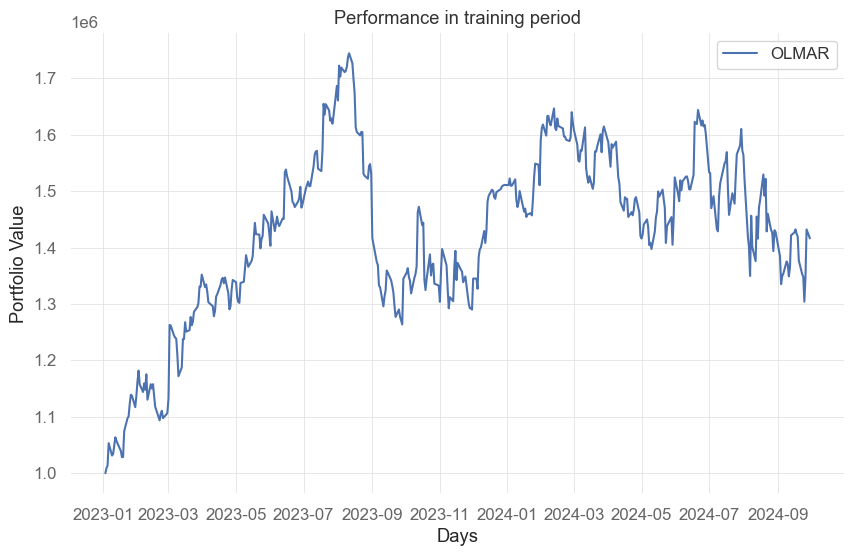

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(OLMAR_results["date"], OLMAR_results["training"], label="OLMAR")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

tic               AAPL        AMGN         AXP          BA         CAT  \
date                                                                     
2023-01-03  123.904625  247.431015  143.260452  195.389999  230.392593   
2023-01-04  125.182610  250.022095  146.590729  203.639999  232.784470   
2023-01-05  123.855087  252.357880  143.082779  204.990005  231.742859   
2023-01-06  128.412201  260.244659  146.737305  213.000000  240.018005   
2023-01-09  128.937286  255.440735  146.962036  208.570007  237.857590   
...                ...         ...         ...         ...         ...   
2024-09-24  227.369995  330.920013  265.516205  155.809998  384.548370   
2024-09-25  226.369995  312.859985  265.476318  152.220001  376.895874   
2024-09-26  227.520004  319.100006  267.451141  154.580002  389.560364   
2024-09-27  227.789993  322.670013  270.353546  156.320007  389.679932   
2024-09-30  233.000000  322.209991  270.493195  152.039993  389.719788   

tic                CRM       CSCO    

c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:243: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill")


Weights!!!!
AAPL    0.0
AMGN    0.0
AXP     0.0
BA      0.0
CAT     0.0
CRM     0.0
CSCO    0.0
CVX     0.0
DIS     0.0
GS      0.0
HD      0.0
HON     0.0
IBM     0.0
INTC    0.0
JNJ     0.0
JPM     0.0
KO      0.0
MCD     0.0
MMM     0.0
MRK     0.0
MSFT    0.0
NKE     0.0
PG      0.0
TRV     0.0
UNH     0.0
V       0.0
VZ      0.0
WBA     1.0
WMT     0.0
dtype: float64
Price2!!!!
AAPL    1.506761
AMGN    1.011796
AXP     1.100284
BA      1.171247
CAT     1.199886
CRM     1.595489
CSCO    1.212590
CVX     0.946874
DIS     0.947286
GS      0.971154
HD      1.068544
HON     0.894056
IBM     1.076829
INTC    1.317625
JNJ     0.939212
JPM     1.120921
KO      0.975344
MCD     1.087272
MMM     0.890410
MRK     1.005198
MSFT    1.381724
NKE     0.865079
PG      1.035560
TRV     0.871613
UNH     0.955008
V       1.194166
VZ      0.907456
WBA     0.720814
WMT     1.135468
Name: 2023-08-30 00:00:00, dtype: float64
Weights!!!!
AAPL    0.0
AMGN    0.0
AXP     0.0
BA      0.0
CAT     0.0
CRM    

c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:252: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:252: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:252: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:252: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\The

                AAPL      AMGN       AXP        BA       CAT       CRM  \
date                                                                     
2023-01-03  0.034483  0.034483  0.034483  0.034483  0.034483  0.034483   
2023-01-04  0.034483  0.034483  0.034483  0.034483  0.034483  0.034483   
2023-01-05  0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   
2023-01-06  0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   
2023-01-09  0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
2024-09-24  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2024-09-25  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2024-09-26  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
2024-09-27  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
2024-09-30  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                CSCO       CVX       

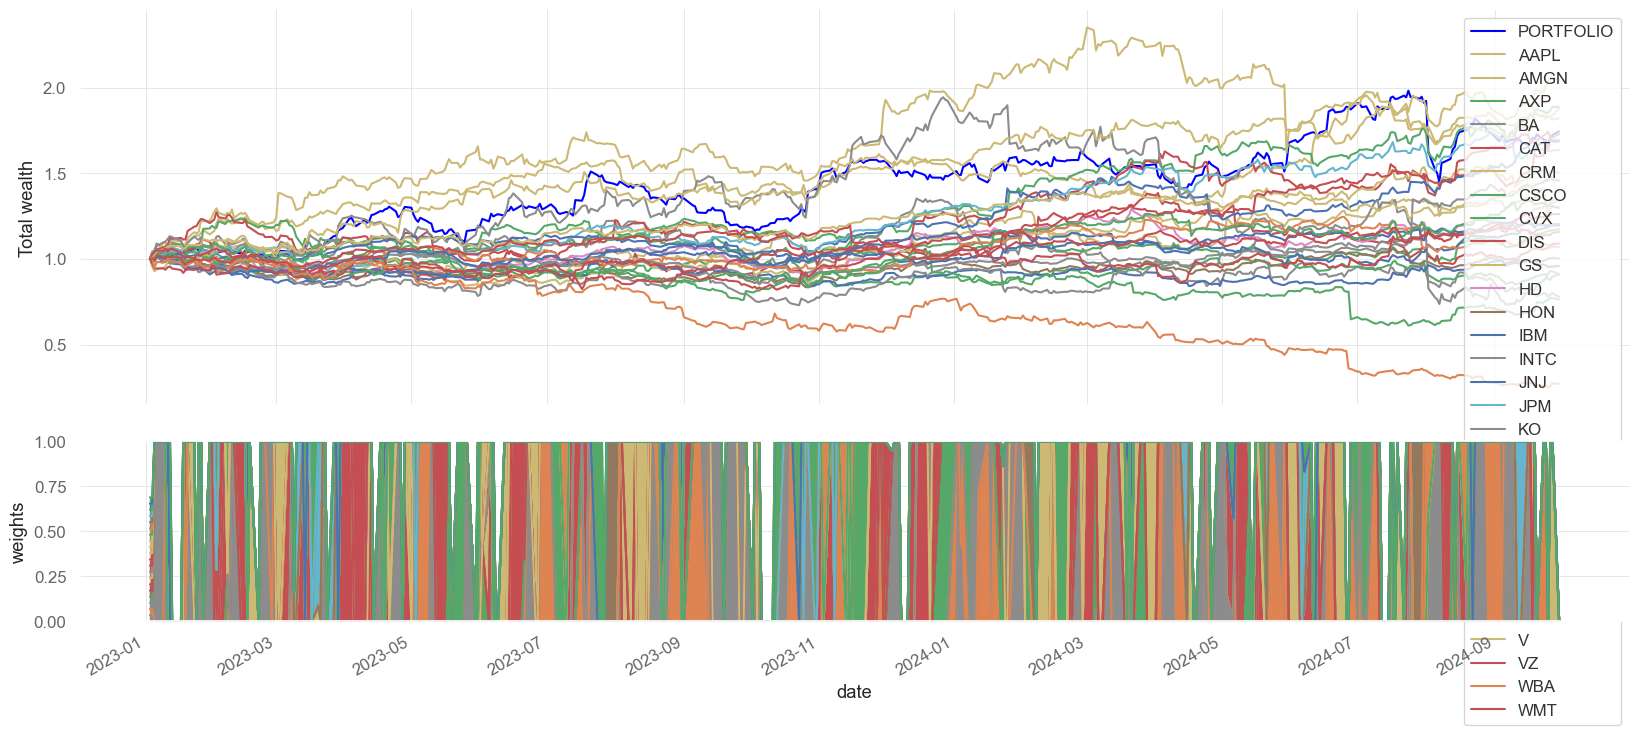

In [23]:
from online_algos import OLMAR

pivot_df = raw_df.pivot(index='date', columns='tic', values='close')

print(pivot_df)

pivot_df.index = pd.to_datetime(pivot_df.index)



algo = OLMAR(window=5, eps=10, ma_type="SMA")

result_olmar = algo.run(pivot_df)
print(result_olmar.summary())
result_olmar.plot()

print(result_olmar.B)

dimensions = result_olmar.B.shape 
print("Dimensions of the DataFrame:", dimensions)

In [24]:
# X = raw_df / raw_df.shift(1).fillna(method="ffill")

# X = X.fillna(1.0)


# pivoted_df = raw_df.pivot(index='date', columns='tic', values='close')
# print(pivoted_df)

print(pivot_df)

X = pivot_df / pivot_df.shift(1).fillna(method="ffill")

X = X.fillna(1.0)
print(X)

tic               AAPL        AMGN         AXP          BA         CAT  \
date                                                                     
2023-01-03  123.904625  247.431015  143.260452  195.389999  230.392593   
2023-01-04  125.182610  250.022095  146.590729  203.639999  232.784470   
2023-01-05  123.855087  252.357880  143.082779  204.990005  231.742859   
2023-01-06  128.412201  260.244659  146.737305  213.000000  240.018005   
2023-01-09  128.937286  255.440735  146.962036  208.570007  237.857590   
...                ...         ...         ...         ...         ...   
2024-09-24  227.369995  330.920013  265.516205  155.809998  384.548370   
2024-09-25  226.369995  312.859985  265.476318  152.220001  376.895874   
2024-09-26  227.520004  319.100006  267.451141  154.580002  389.560364   
2024-09-27  227.789993  322.670013  270.353546  156.320007  389.679932   
2024-09-30  233.000000  322.209991  270.493195  152.039993  389.719788   

tic                CRM       CSCO    

C:\Users\bencj\AppData\Local\Temp\ipykernel_4604\2061739489.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = pivot_df / pivot_df.shift(1).fillna(method="ffill")
